In [1]:
import matplotlib.pyplot as plt
import csv
from contextualized_topic_models.models.ctm import ZeroShotTM
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
import nltk
from nltk.corpus import stopwords as stop_words
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import sys
import os
import requests
sys.path.append("../")
from src import puhti_files
from src.common_basis import *

Database password (connection attempt failed with (pymysql.err.OperationalError) (1045, "Access denied for user 'hpc-hd-ro'@'puhti-nat-2.csc.fi' (using password: NO)")
(Background on this error at: https://sqlalche.me/e/20/e3q8)): ········


In [3]:
SEED = 42
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = puhti_files.genre_data_to_pandas(data="dev", add_labels=True, merge_ecco=True)
df = df[~df['publication_year'].isna()]
df['decade'] = df['publication_year'].apply(lambda x: int(str(int(x))[:-1]+'0'))

Read in dataset dev.csv. Set param 'data' to 'dev', 'test' or 'train' if you want another dataset.


In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/sebarodr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
df['work_id'].unique().tolist()

['X-biographical sketches of some of the leading men at present at the head of affairs in france',
 '19754-rudiments and practical exercises for learning french language',
 '1-liturgies',
 '1519-new history of holy bible',
 '1653-thesaurus linguae latinae compendiarius',
 '479-man of feeling',
 '5631-britains commercial interest explained and improved',
 '35-meditations and contemplations in two volumes',
 '45-colloquia',
 '28-seasons',
 '240-quinti horatii flacci venusini poetae lyrici poemata omnia doctissimis scholijs and nouis aliquot annotatiunculis illustrata',
 '172-tom jones',
 '56488-excursion in two volumes',
 '4725-a new abridgment of law',
 '317-sir charles grandison',
 '199-royal dictionary',
 '21200-characteristics of present political state of great britain',
 '13-aesops fables',
 '885-letters',
 '282-epigrammata',
 'X-the adventurer',
 '277-practical treatise upon christian perfection',
 '2203-chronology or historians vade mecum',
 '20990-law of devises revocations and 

In [8]:
df[df['work_id']=='74-hamlet']

document_id    work_id  main_category  sub_category main_category_label  \
259   0748401400  74-hamlet              0             0                Arts   
322   1409801300  74-hamlet              0             0                Arts   
323   1409801300  74-hamlet              0             0                Arts   
647   0961100700  74-hamlet              0             0                Arts   
731   1332800900  74-hamlet              0             0                Arts   
1349  1683400100  74-hamlet              0             0                Arts   

         sub_category_label publication_year gatherings  total_price  \
259   artstheatreplaysopera             1723       12mo         12.0   
322   artstheatreplaysopera             1794       12mo          NaN   
323   artstheatreplaysopera             1794       12mo          NaN   
647   artstheatreplaysopera             1720        8vo          NaN   
731   artstheatreplaysopera             1736       12mo          NaN   
1349  artstheatreplaysopera             1743       12mo          NaN   

     publication_place  author_id                        other_actors  decade  
259             London   96994048  bbti_105106; bbti_109905; 36768263    1720  
322          Boston Ma   96994048                    1499137; 3961256    1790  
323          Boston Ma  146686953                    1499137; 3961256    1790  
647                NaN   96994048                          bbti_38273    1720  
731             London   96994048                         bbti_125482    1730  
1349            London   96994048    150016994; bbti_109575; 12361047    1740

In [9]:
#Topic classifications, combining both sebastian and Eli analisis.
# NA - > The topic only contains weird tokens, doesn't represent anything
topics_names = {1720:{1:'Religion',2:'Goverment/Royal',3:'Romance',4:'Prayer/Bible',5:'Social',6:'Law',7:'Science',8:'Kings',9:'Verbs?/War?',10:'War?'},
                1730:{1:'Religion',2:'Goverment/Kingdom',3:'Religion',4:'Social Concepts',5:'State',6:'Romance',7:'Nature',8:'Locations/People',9:'Kings',10:'Bigger Concepts'},
                1740:{1:'Religion',2:'Romance',3:'Religion',4:'Philosophy',5:'War/Kingdom',6:'Romance',7:'Nature',8:'Law',9:'Royalty',10:'NA?'},
                1750:{1:'Bible/Religion',2:'Romance/Religion',3:'Religion',4:'Nature',5:'Kingdom',6:'Mankind',7:'Kingdom',8:'Country/Issues',9:'NA',10:'NA'},
                1760:{1:'Bible/Religion',2:'State Affairs',3:'Religion',4:'Kingdom',5:'Love/Family',6:'Government affairs',7:'Love/Religious Concepts',8:'Nature',9:'Philosophy',10:'NA'},
                1770:{1:'Kingdom/War',2:'Law/Court',3:'Love/Religion',4:'Higher Power',5:'Nature',6:'Mankind',7:'Kingdom',8:'Love',9:'Church/Religion',10:'NA'},
                1780:{1:'Prayer/Bible',2:'War',3:'Romance',4:'Mandkind',5:'Religion',6:'Law',7:'Trade/Economy',8:'Court/Kingdom',9:'Medicine',10:'NA'},
                1790:{1:'Love',2:'Literature?',3:'Law',4:'Religion',5:'Parliament',6:'Mankind',7:'Romance',8:'Ingredients?',9:'Countries/Land/Economy',10:'NA'}}

In [10]:
topics_names2 = {1720:{9:'Religion',3:'Goverment/Royal',4:'Romance',6:'Prayer/Bible',7:'Social',5:'Law',10:'Science',1:'Kings',2:'Verbs?/War?',8:'War?'},
                1730:{4:'Religion',9:'Goverment/Kingdom',7:'Religion',2:'Social Concepts',3:'State',10:'Romance',8:'Nature',1:'Locations/People',6:'Kings',5:'Bigger Concepts'},
                1740:{5:'Religion',7:'Romance',2:'Religion',10:'Philosophy',1:'War/Kingdom',8:'Romance',6:'Nature',4:'Law',9:'Royalty',3:'NA?'},
                1750:{9:'Bible/Religion',3:'Romance/Religion',4:'Religion',10:'Nature',7:'Kingdom',8:'Mankind',1:'Kingdom',6:'Country/Issues',2:'NA',5:'NA'},
                1760:{5:'Bible/Religion',9:'State Affairs',6:'Religion',4:'Kingdom',1:'Love/Family',7:'Government affairs',3:'Love/Religious Concepts',2:'Nature',10:'Philosophy',8:'NA'},
                1770:{8:'Kingdom/War',2:'Law/Court',3:'Love/Religion',7:'Higher Power',9:'Nature',5:'Mankind',4:'Kingdom',6:'Love',10:'Church/Religion',1:'NA'},
                1780:{8:'Prayer/Bible',2:'War',5:'Romance',4:'Mandkind',7:'Religion',3:'Law',9:'Trade/Economy',10:'Court/Kingdom',6:'Medicine',1:'NA'},
                1790:{2:'Love',5:'Literature?',3:'Law',7:'Religion',4:'Parliament',10:'Mankind',6:'Romance',9:'Ingredients?',8:'Countries/Land/Economy',1:'NA'}}

In [11]:
new_topics = {}
for j in topics_names2.keys():
    myKeys = list(topics_names2[j].keys())
    myKeys.sort()
    sorted_dict = {i: topics_names2[j][i] for i in myKeys}
    new_topics[j] = sorted_dict

In [12]:
new_topics

{1720: {1: 'Kings',
  2: 'Verbs?/War?',
  3: 'Goverment/Royal',
  4: 'Romance',
  5: 'Law',
  6: 'Prayer/Bible',
  7: 'Social',
  8: 'War?',
  9: 'Religion',
  10: 'Science'},
 1730: {1: 'Locations/People',
  2: 'Social Concepts',
  3: 'State',
  4: 'Religion',
  5: 'Bigger Concepts',
  6: 'Kings',
  7: 'Religion',
  8: 'Nature',
  9: 'Goverment/Kingdom',
  10: 'Romance'},
 1740: {1: 'War/Kingdom',
  2: 'Religion',
  3: 'NA?',
  4: 'Law',
  5: 'Religion',
  6: 'Nature',
  7: 'Romance',
  8: 'Romance',
  9: 'Royalty',
  10: 'Philosophy'},
 1750: {1: 'Kingdom',
  2: 'NA',
  3: 'Romance/Religion',
  4: 'Religion',
  5: 'NA',
  6: 'Country/Issues',
  7: 'Kingdom',
  8: 'Mankind',
  9: 'Bible/Religion',
  10: 'Nature'},
 1760: {1: 'Love/Family',
  2: 'Nature',
  3: 'Love/Religious Concepts',
  4: 'Kingdom',
  5: 'Bible/Religion',
  6: 'Religion',
  7: 'Government affairs',
  8: 'NA',
  9: 'State Affairs',
  10: 'Philosophy'},
 1770: {1: 'NA',
  2: 'Law/Court',
  3: 'Love/Religion',
  4: 'Ki

In [13]:
topics_names = new_topics

In [14]:
topics_df = pd.DataFrame.from_dict(topics_names)
topics_df

1720               1730         1740              1750  \
1             Kings   Locations/People  War/Kingdom           Kingdom   
2       Verbs?/War?    Social Concepts     Religion                NA   
3   Goverment/Royal              State          NA?  Romance/Religion   
4           Romance           Religion          Law          Religion   
5               Law    Bigger Concepts     Religion                NA   
6      Prayer/Bible              Kings       Nature    Country/Issues   
7            Social           Religion      Romance           Kingdom   
8              War?             Nature      Romance           Mankind   
9          Religion  Goverment/Kingdom      Royalty    Bible/Religion   
10          Science            Romance   Philosophy            Nature   

                       1760             1770           1780  \
1               Love/Family               NA             NA   
2                    Nature        Law/Court            War   
3   Love/Religious Concepts    Love/Religion            Law   
4                   Kingdom          Kingdom       Mandkind   
5            Bible/Religion          Mankind        Romance   
6                  Religion             Love       Medicine   
7        Government affairs     Higher Power       Religion   
8                        NA      Kingdom/War   Prayer/Bible   
9             State Affairs           Nature  Trade/Economy   
10               Philosophy  Church/Religion  Court/Kingdom   

                      1790  
1                       NA  
2                     Love  
3                      Law  
4               Parliament  
5              Literature?  
6                  Romance  
7                 Religion  
8   Countries/Land/Economy  
9             Ingredients?  
10                 Mankind

In [15]:
#df = pd.read_table('/scratch/project_2007227/genre_data/ecco_metadata.tsv')
#df = df[~df['publication_year'].isna()]
#df['decade'] = df['publication_year'].apply(lambda x: int(str(int(x))[:-1]+'0'))

In [16]:
#Original visualization, just for one book. It must receive an ID that is a str
def book_pattern_vis(id, chunksize=512, ybottom=0):
    #We need to identify the age of the book to use the correct model. Extract year from metadata
    id= str(id)
    year = 1720
    try:
        year = df[df['document_id'] ==id]['publication_year'].values[0]
    except:
        print('Doc id not found')
    year = int(year)
    work_id = df[df['document_id'] ==id]['work_id'].values[0]
    #if the book is from earlier era than 1720, gives erros since we don't have model from that era.
    if year < 1720:
        print('Publication year of the document is not included in the models, please try another document.')
        return True
    
    #if the book is ok, we need to first preprocess the document for the model
    
    #First divide the text into chunks
    with open('/scratch/project_2007227/genre_data/ecco_source/'+str(id)+'.txt', 'r') as f:
        lines = f.readlines()
    
    num_lines = len(lines)
    text = " ".join(lines)
    new_text = '\n'.join([text[i:i+chunksize] for i in range(0, len(text), chunksize)])
    
    with open('/scratch/project_2007227/genre_data/chunk512/'+str(id)+'512.txt', 'w') as f:
        f.write(new_text)
              
    text_file = '/scratch/project_2007227/genre_data/chunk512/'+str(id)+'512.txt'
    documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]]

    stopwords = list(stop_words.words("english"))

    sp = WhiteSpacePreprocessingStopwords(documents, stopwords_list=stopwords)
    preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
    
    
    #tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")
    #processed_data= tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
    
    #Nextly we fetch the model that corresponds to the publication year
    modelnumber = ((year // 10) % 10)-2
    decade = int(str(int(year))[:-1]+'0')
    with open('/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/tp_models/tp_model'+str(modelnumber)+'.pickle', 'rb') as tpmodel:
        tpmodeli = pickle.load(tpmodel)

    ctm = ZeroShotTM(bow_size=len(tpmodeli.vocab), contextual_size=768, n_components=10, num_epochs=20)
    ctm.load("/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/ctm_models"+str(modelnumber)+"/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99",
                                                                                                          epoch=19)
    processed_data = tpmodeli.transform(unpreprocessed_corpus)
    pred_model = ctm.get_thetas(processed_data, n_samples=20) 
    
    plt.figure(figsize=(10,8))
    plt.plot(pred_model, '.')
    
    plt.ylim((ybottom,1))
    plt.title('Sequential genre prediction for document '+str(id)+' in with 512 token chunks. The document is from the decade '+str(decade) + '. With work id ' + str(work_id))
    plt.legend(topics_names[decade].values(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/utils/data_preparation.py:192: UserWarning: The method did not have in input the text_for_bow parameter. This IS EXPECTED if you are using ZeroShotTM in a cross-lingual setting
  warnings.warn(


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/75 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

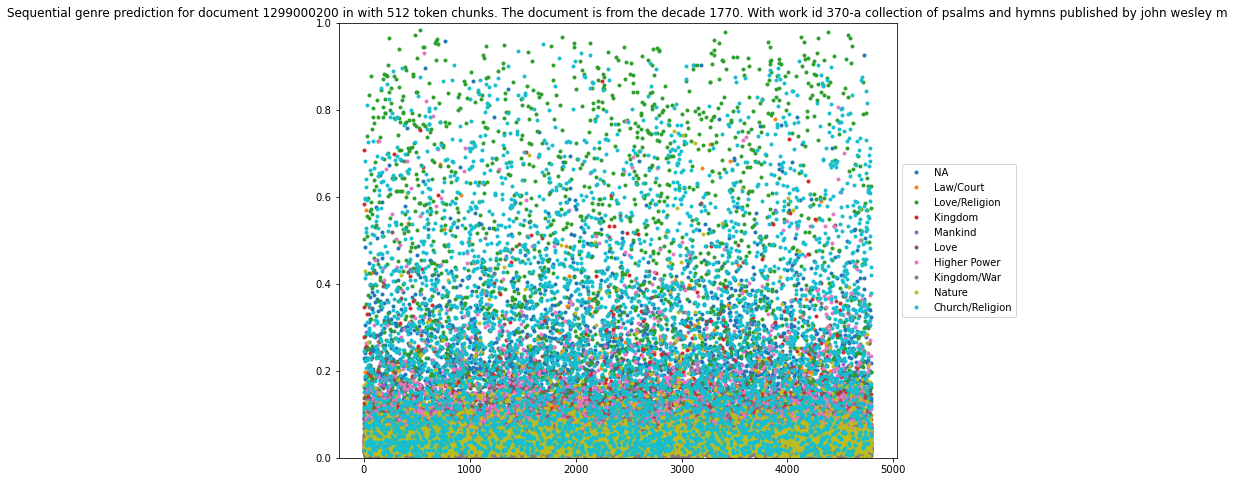

In [17]:
book_pattern_vis('1299000200')
#Currently the method doesn't support ids starting with 0, to address this feel free to modify str<->int in the code, 

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-16-a7ecd67a956e>:31: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/0748401400512.txt' mode='r' encoding='utf-8'>
  documents = [line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]]
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/contextua

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/63 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

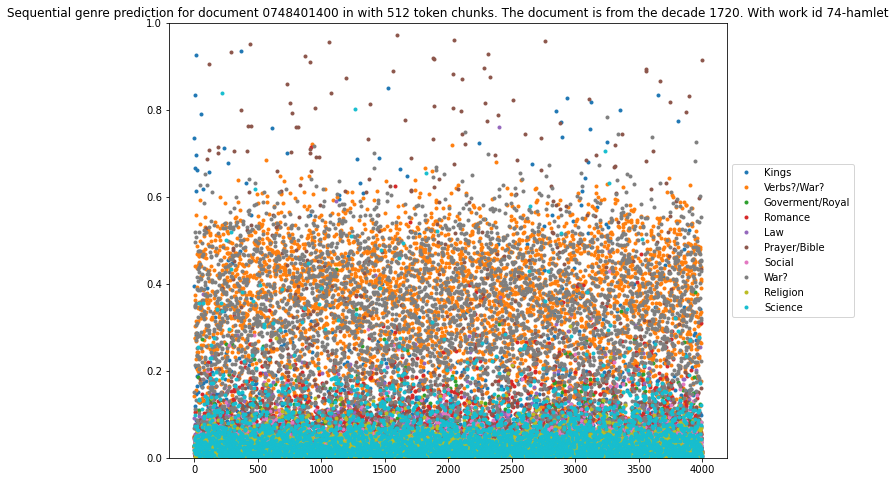

In [18]:
book_pattern_vis('0748401400')

In [19]:
#Method that given a decade, will visualize 6 samples of it.
#If random_state is True, it will always use the same random state seed, which means that it will always return the same samples
#To see different documents, use random_state=False, so it shows a completly random sample of 6 documents
def book_pattern_vis_sample(decade, chunksize=512, ybottom=0,num_samples=6,random_state=True):
    #We need to identify the age of the book to use the correct model. Extract year from metadata
    if random_state:
        samples = df[df['decade']==decade].sample(n = num_samples,random_state=423)
    else:
        samples = df[df['decade']==decade].sample(n = num_samples)

    ids = samples['document_id'].tolist()
    works_ids = samples['work_id'].tolist()
    stopwords = list(stop_words.words("english"))
    
    modelnumber = ((decade // 10) % 10)-2
    #decade = int(str(int(year))[:-1]+'0')
    with open('/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/tp_models/tp_model'+str(modelnumber)+'.pickle', 'rb') as tpmodel:
        tpmodeli = pickle.load(tpmodel)

    ctm = ZeroShotTM(bow_size=len(tpmodeli.vocab), contextual_size=768, n_components=10, num_epochs=20)
    ctm.load("/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/ctm_models"+str(modelnumber)+"/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99",
                                                                                                          epoch=19)
    
    #First divide the text into chunks
    documents = []
    for i in ids:
        len_id = len(str(i))
        if len_id<10:
            i = '0'*(10 - len_id) + str(i)
        else:
            i = str(i)
        with open('/scratch/project_2007227/genre_data/ecco_source/'+str(i)+'.txt', 'r') as f:
            lines = f.readlines()
            num_lines = len(lines)
            text = " ".join(lines)
            new_text = '\n'.join([text[i:i+chunksize] for i in range(0, len(text), chunksize)])
        with open('/scratch/project_2007227/genre_data/chunk512/'+str(i)+'512.txt', 'w') as f:
            f.write(new_text)
        text_file = '/scratch/project_2007227/genre_data/chunk512/'+str(i)+'512.txt'
        documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
    thetas = []
    for i in range(len(documents)):
        sp = WhiteSpacePreprocessingStopwords(documents[i], stopwords_list=stopwords)
        preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
        processed_data = tpmodeli.transform(unpreprocessed_corpus)
        pred_model = ctm.get_thetas(processed_data, n_samples=20) 
        thetas.append(pred_model)
    
    #tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")
    #processed_data= tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
    
    #Nextly we fetch the model that corresponds to the publication year

    figure, axis = plt.subplots(2, 3, figsize=(16,12),squeeze=False)
    for i in range(len(thetas)):
        axis[i%2, i%3].plot(thetas[i], '.')
        axis[i%2, i%3].axis(ymin=ybottom,ymax=1)
        axis[i%2, i%3].set_title(f"work id {str(works_ids[i])[:50]}")
        
    figure.legend(topics_names[decade].values(),loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-19-e13be0e9bd37>:40: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/0017200200512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-19-e13be0e9bd37>:40: ResourceWarning: un

Batches:   0%|          | 0/52 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/163 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/84 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/261 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/48 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/190 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/593 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/138 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/56 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/175 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

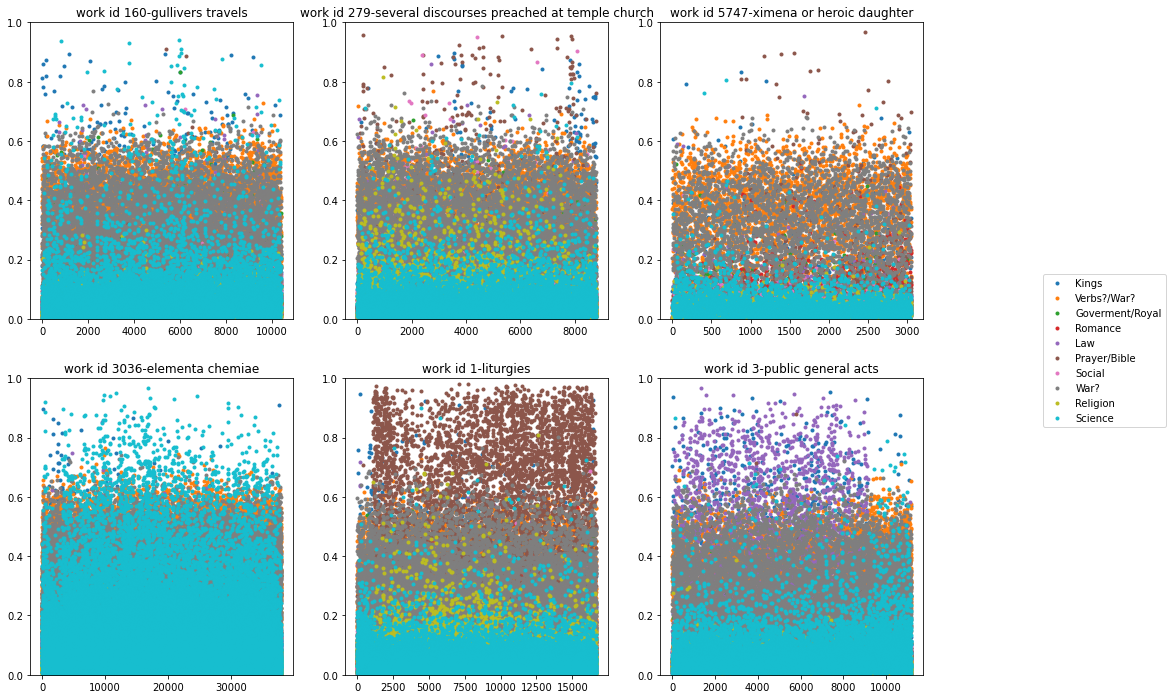

In [20]:
book_pattern_vis_sample(1720,random_state=True)

In [39]:
#Method that uses pre_loaded test datasets to visualize. The problem is that it can only use the chunks, 
#but it doesn't have the original document
def test_loaded_sets(decade):
    modelnumber = ((decade // 10) % 10)-2
    test_sets = []
    with open('/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/tp_models/tp_model'+str(modelnumber)+'.pickle', 'rb') as tpmodel:
        tpmodeli = pickle.load(tpmodel)

    ctm = ZeroShotTM(bow_size=len(tpmodeli.vocab), contextual_size=768, n_components=10, num_epochs=20)
    ctm.load("/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/ctm_models"+str(modelnumber)+"/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99",
                                                                                                          epoch=19)

    with open('/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/Test_sets/test_set'+str(modelnumber)+'.pickle', 'rb') as dataset:
        dataseti = pickle.load(dataset)
        test_sets.append(dataseti)

    thetas = []
    for i in test_sets:
        pred_model = ctm.get_thetas(i, n_samples=20)
        thetas.append(pred_model)
    indexes = []
    vals = []
    for key,val in topics_names[decade].items():
        if val == 'NA' or val == 'NA?':
            indexes.append(key-1)
        else:
            vals.append(val)
    
    thetas = np.array(thetas)
    thetas_ov = np.mean(thetas,axis=1)
    thetas_ov = np.squeeze(thetas)
    thetas_ov = np.delete(thetas_ov, indexes, 1)
    plt.figure(figsize=(10,8))
    plt.plot(thetas_ov, '.')
    plt.ylim((0,1))
    plt.title('Topic prediction for test set with  '+str(thetas_ov.shape[0])+' chunks. The documents are from the decade '+str(decade))
    plt.legend(vals,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

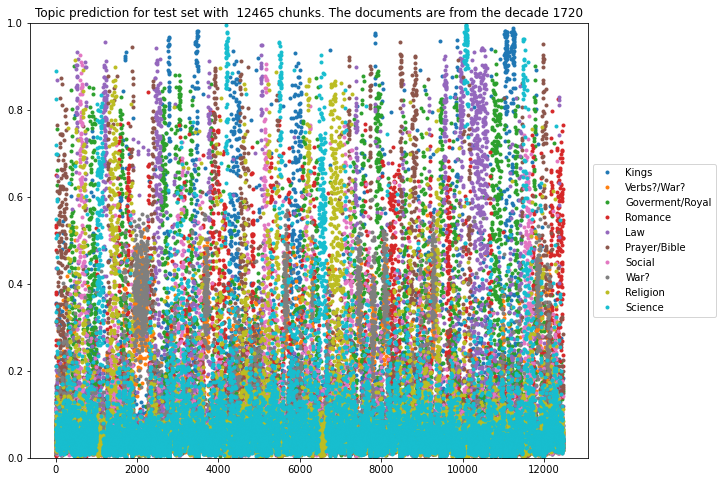

In [40]:
test_loaded_sets(1720)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

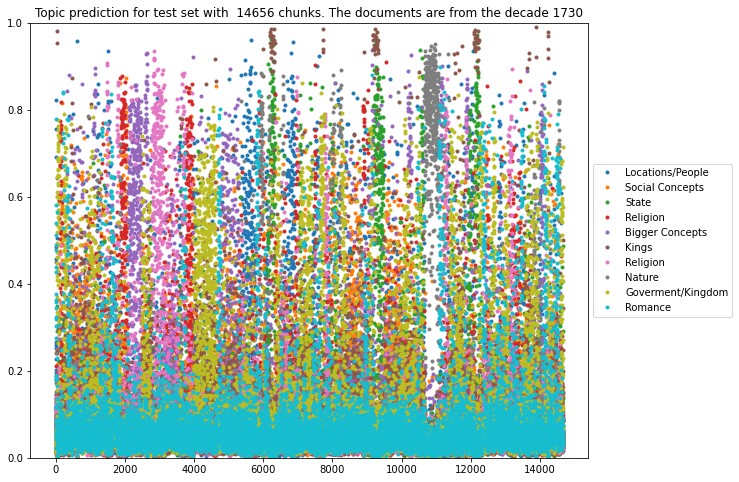

In [41]:
test_loaded_sets(1730)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

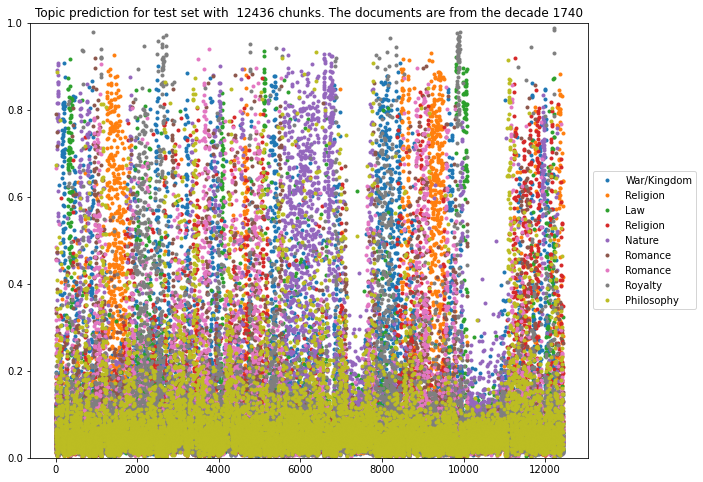

In [42]:
test_loaded_sets(1740)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

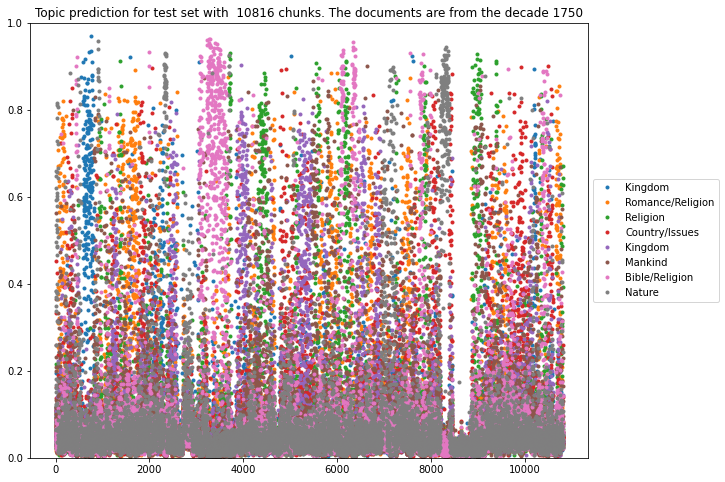

In [43]:
test_loaded_sets(1750)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

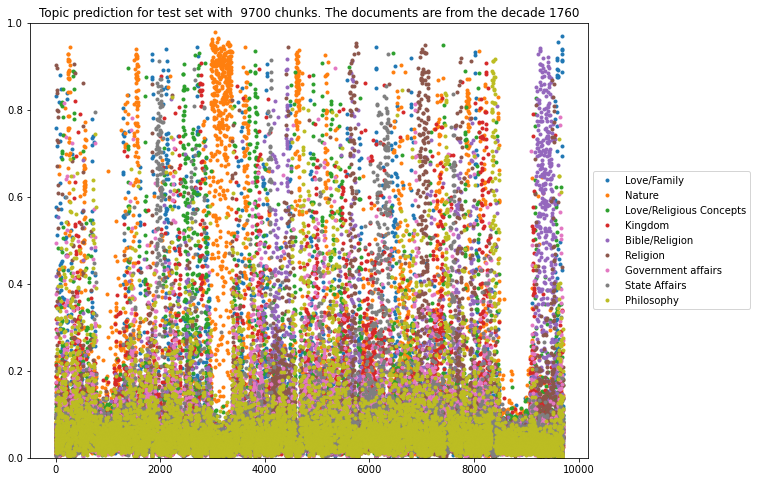

In [44]:
test_loaded_sets(1760)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

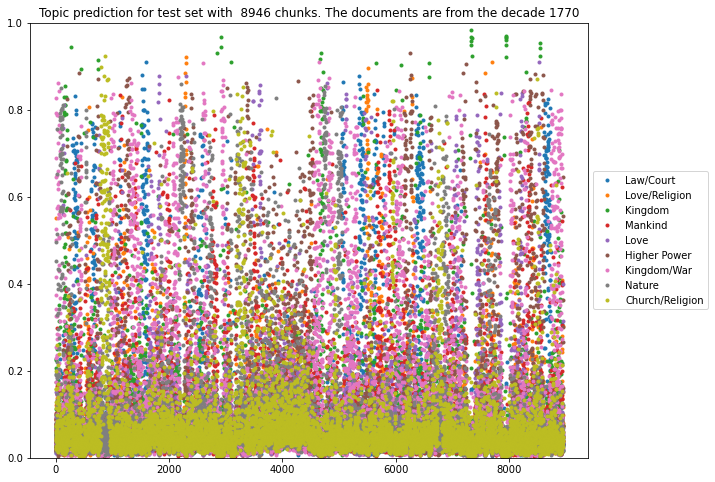

In [45]:
test_loaded_sets(1770)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

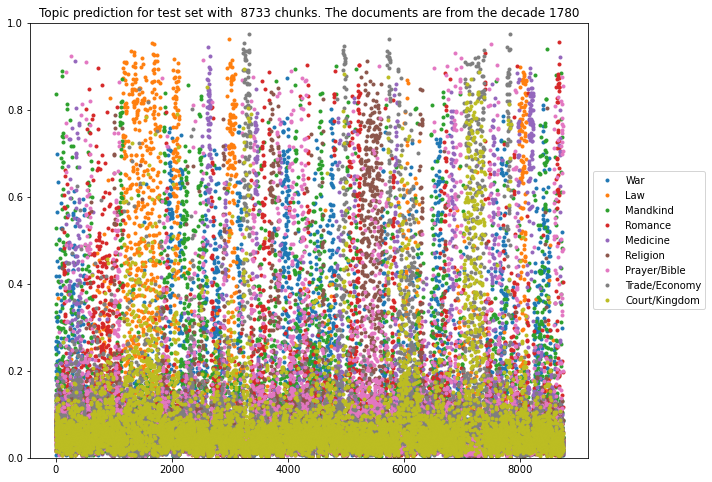

In [46]:
test_loaded_sets(1780)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLo

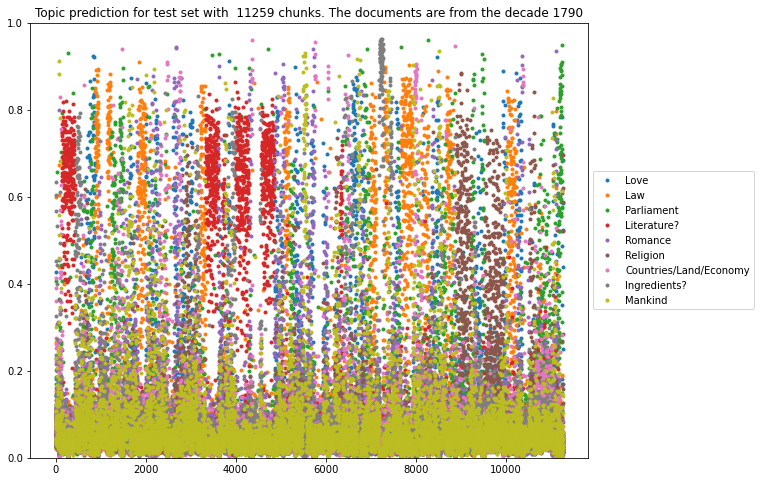

In [47]:
test_loaded_sets(1790)

In [48]:
#Method that will sample 6 documents from the given decade and genre.
#The decade must be between 1720 and 1790, and the genre must be the name of the genre, not the number.
#If random_state is True, it will always use the same random state seed, which means that it will always return the same samples
#To see different documents, use random_state=False, so it shows a completly random sample of 6 documents
def sample_per_decade_and_genre(decade,genre, chunksize=512, ybottom=0,num_samples=6,random_state=True):
    #We need to identify the age of the book to use the correct model. Extract year from metadata
    if random_state:
        filt = df[(df['decade']==decade) & (df['main_category_label']==genre)]
        samples = filt.sample(n = min(num_samples,filt.shape[0]),random_state=423)
    else:
        filt = df[(df['decade']==decade) & (df['main_category_label']==genre)]
        samples = filt.sample(n = min(num_samples,filt.shape[0]))

    ids = samples['document_id'].tolist()
    works_ids = samples['work_id'].tolist()
    stopwords = list(stop_words.words("english"))
    
    modelnumber = ((decade // 10) % 10)-2
    #decade = int(str(int(year))[:-1]+'0')
    with open('/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/tp_models/tp_model'+str(modelnumber)+'.pickle', 'rb') as tpmodel:
        tpmodeli = pickle.load(tpmodel)

    ctm = ZeroShotTM(bow_size=len(tpmodeli.vocab), contextual_size=768, n_components=10, num_epochs=20)
    ctm.load("/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/ctm_models"+str(modelnumber)+"/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99",
                                                                                                          epoch=19)
    
    #First divide the text into chunks
    documents = []
    for i in ids:
        len_id = len(str(i))
        if len_id<10:
            i = '0'*(10 - len_id) + str(i)
        else:
            i = str(i)
        with open('/scratch/project_2007227/genre_data/ecco_source/'+str(i)+'.txt', 'r') as f:
            lines = f.readlines()
            num_lines = len(lines)
            text = " ".join(lines)
            new_text = '\n'.join([text[i:i+chunksize] for i in range(0, len(text), chunksize)])
        with open('/scratch/project_2007227/genre_data/chunk512/'+str(i)+'512.txt', 'w') as f:
            f.write(new_text)
        text_file = '/scratch/project_2007227/genre_data/chunk512/'+str(i)+'512.txt'
        documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
    indexes = []
    vals = []
    for key,val in topics_names[decade].items():
        if val == 'NA' or val == 'NA?':
            indexes.append(key-1)
        else:
            vals.append(val)
    thetas = []
    for i in range(len(documents)):
        sp = WhiteSpacePreprocessingStopwords(documents[i], stopwords_list=stopwords)
        preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
        processed_data = tpmodeli.transform(unpreprocessed_corpus)
        pred_model = ctm.get_thetas(processed_data, n_samples=20) 
        pred_model = np.delete(pred_model, indexes, 1)
        thetas.append(pred_model)
    
    #tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")
    #processed_data= tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
    
    #Nextly we fetch the model that corresponds to the publication year

    figure, axis = plt.subplots(2, 3, figsize=(16,12),squeeze=False)
    for i in range(len(thetas)):
        axis[i%2, i%3].plot(thetas[i], '.')
        axis[i%2, i%3].axis(ymin=ybottom,ymax=1)
        axis[i%2, i%3].set_title(f"work id {str(works_ids[i])[:50]}")
        
    figure.legend(vals,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
#Here are the different labels that can be used in the following method
df['main_category_label'].unique()

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['History', 'Scientific Improvement', 'Religion', 'Literature',
       'Philosophy', 'Sales Catalogues', 'Law', 'Arts', 'Education',
       'Politics'], dtype=object)

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-48-cc9549553c59>:43: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/0233400101512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-48-cc9549553c59>:43: ResourceWarning: un

Batches:   0%|          | 0/97 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/301 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/137 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/428 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/28 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/19 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/164 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/513 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/233 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/727 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

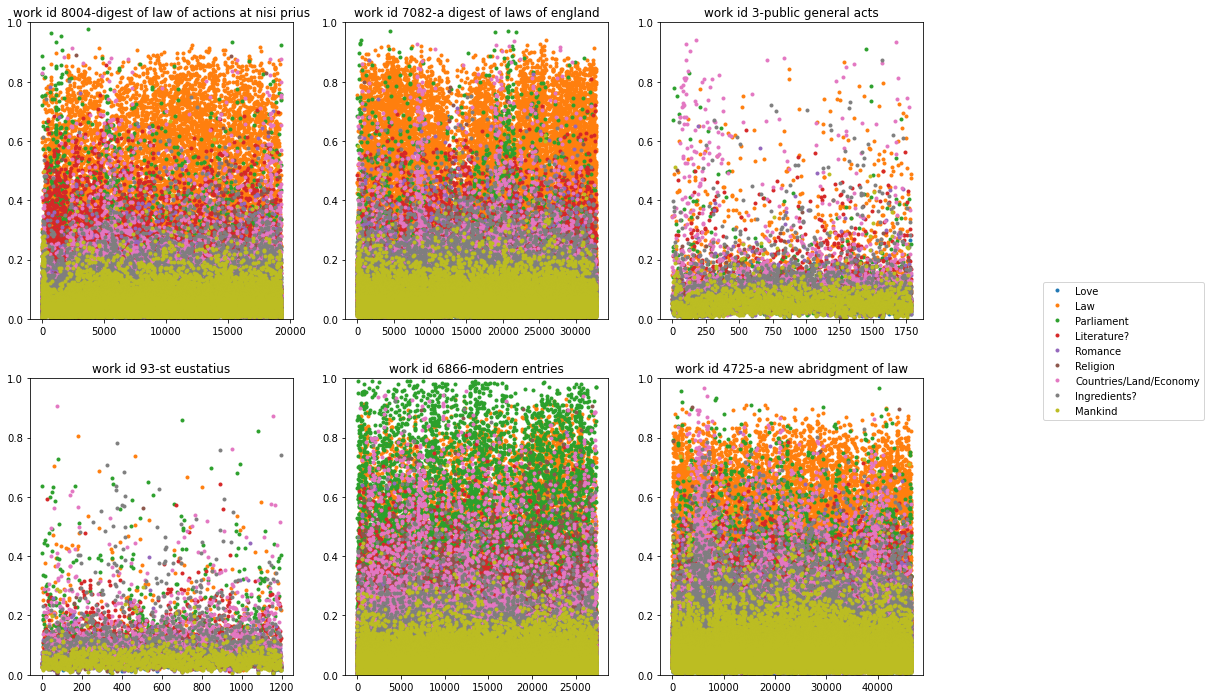

In [50]:
#Example of use
sample_per_decade_and_genre(1790,'Law')

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-48-cc9549553c59>:43: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/0444800106512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-48-cc9549553c59>:43: ResourceWarning: un

Batches:   0%|          | 0/90 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/281 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/41 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/41 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/129 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/105 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/328 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/30 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/94 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

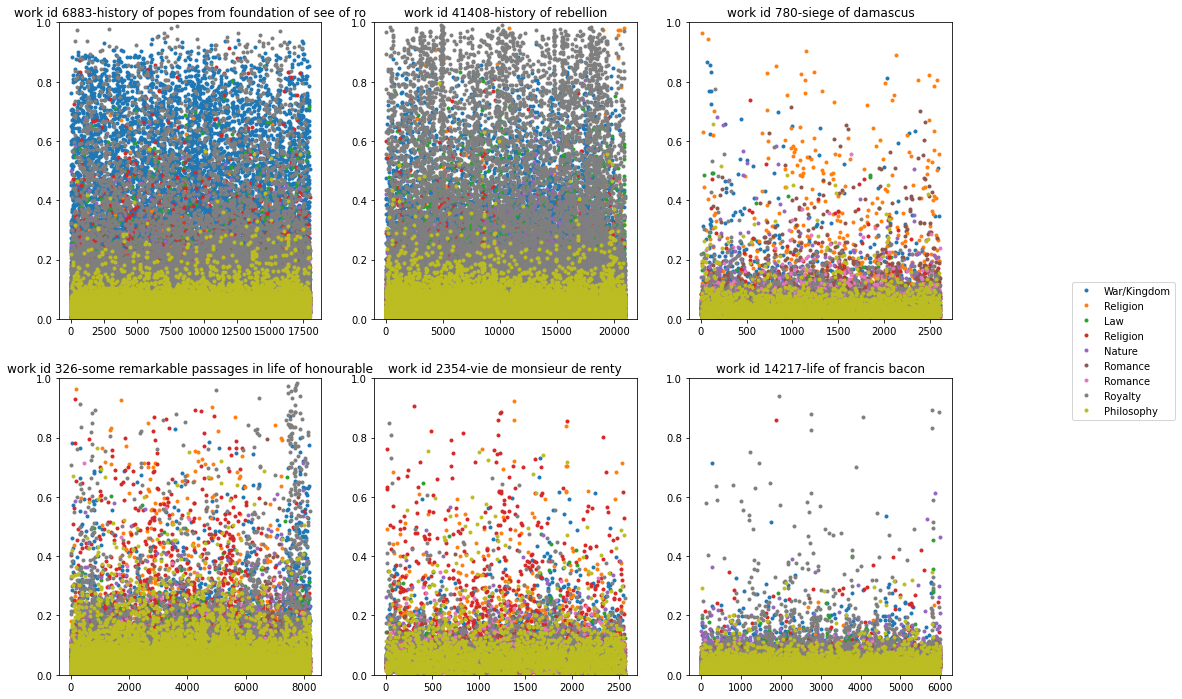

In [51]:
sample_per_decade_and_genre(1740,'History')

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-48-cc9549553c59>:43: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/1273200300512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-48-cc9549553c59>:43: ResourceWarning: un

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/32 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/202 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/54 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/69 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/215 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

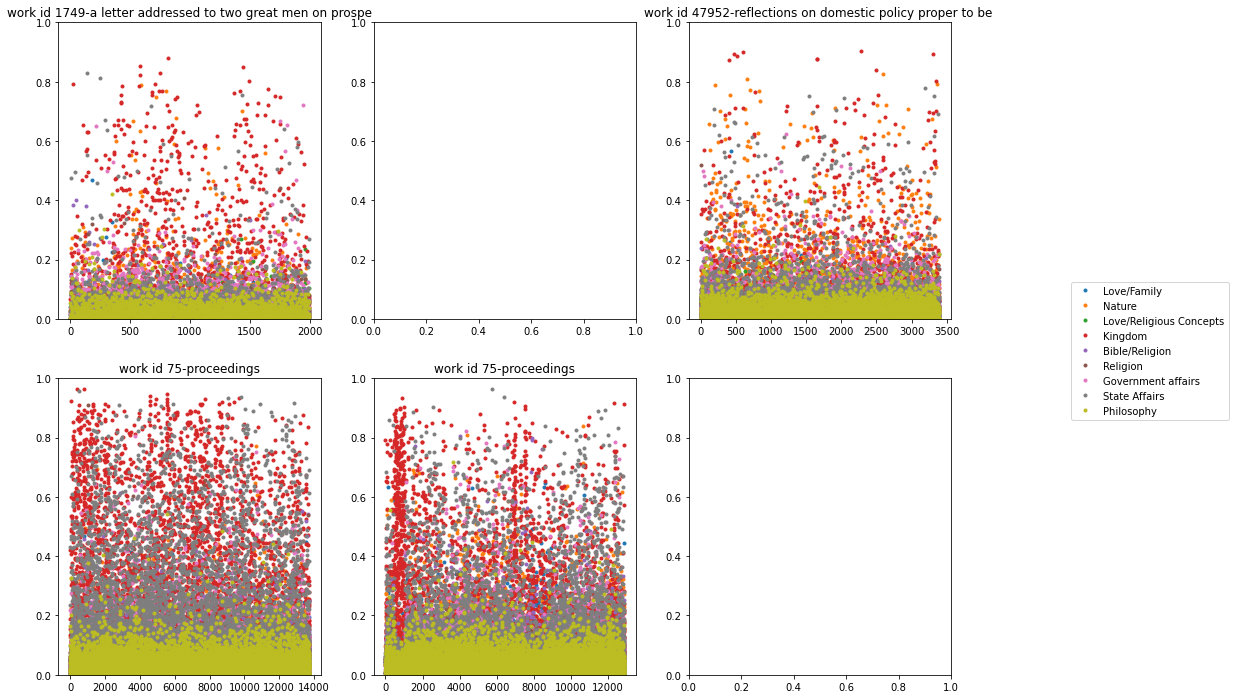

In [52]:
sample_per_decade_and_genre(1760,'Politics')

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-48-cc9549553c59>:43: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/1568500200512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-48-cc9549553c59>:43: ResourceWarning: un

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/8 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_

Batches:   0%|          | 0/125 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/389 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/225 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/21 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/212 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/660 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/94 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

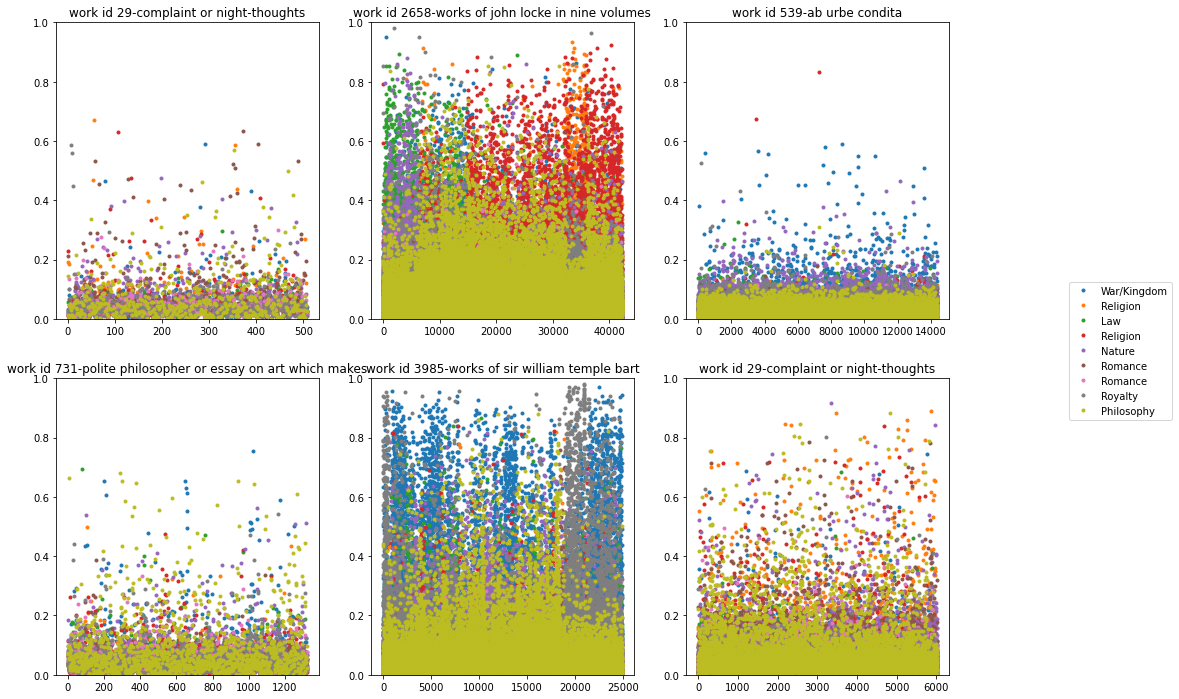

In [53]:
sample_per_decade_and_genre(1740,'Philosophy')

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-48-cc9549553c59>:43: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/0018900102512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-48-cc9549553c59>:43: ResourceWarning: un

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/123 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/62 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/192 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/36 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/111 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/271 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/37 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/151 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

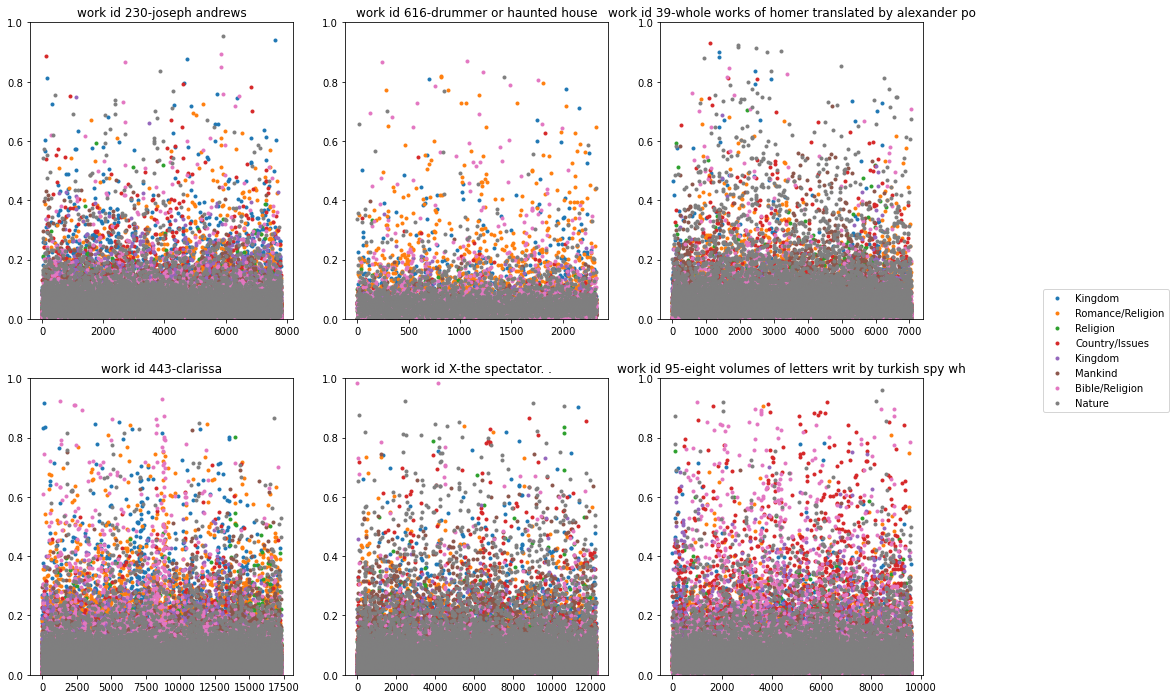

In [54]:
sample_per_decade_and_genre(1750,'Literature')

In [36]:
#Method that will sample 6 documents from the given decade and genre.
#The decade must be between 1720 and 1790, and the genre must be the name of the genre, not the number.
#If random_state is True, it will always use the same random state seed, which means that it will always return the same samples
#To see different documents, use random_state=False, so it shows a completly random sample of 6 documents
def sample_per_genre(genre, chunksize=512, ybottom=0,random_state=True):
    #We need to identify the age of the book to use the correct model. Extract year from metadata
    sampled_df = pd.DataFrame()
    for i in range(1720,1800,10):
        if random_state:
            filt = df[(df['decade']==i) & (df['main_category_label']==genre)]
            samples = filt.sample(n = 3,random_state=423)
            sampled_df = pd.concat([sampled_df,samples])
        else:
            filt = df[(df['decade']==i) & (df['main_category_label']==genre)]
            samples = filt.sample(n = 3)
            sampled_df = pd.concat([sampled_df,samples])
    tp_models = []
    ctm_models = []
    stopwords = list(stop_words.words("english"))
    thetas1 = []
    for i in range(1720,1800,10):
        modelnumber = ((i // 10) % 10)-2
        #decade = int(str(int(year))[:-1]+'0')
        with open('/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/tp_models/tp_model'+str(modelnumber)+'.pickle', 'rb') as tpmodel:
            tpmodeli = pickle.load(tpmodel)
        tp_models.append(tpmodeli)
        ctm = ZeroShotTM(bow_size=len(tpmodeli.vocab), contextual_size=768, n_components=10, num_epochs=20)
        ctm.load("/scratch/project_2007227/genre_data/Digital-Humanities-Project-Genres-2023/src/ctm_models"+str(modelnumber)+"/contextualized_topic_model_nc_10_tpm_0.0_tpv_0.9_hs_prodLDA_ac_(100, 100)_do_softplus_lr_0.2_mo_0.002_rp_0.99",
                                                                                                              epoch=19)
        ctm_models.append(ctm)
    
        #First divide the text into chunks
        ids = sampled_df[sampled_df['decade']==i]['document_id'].tolist()
        works_ids = sampled_df[sampled_df['decade']==i]['work_id'].tolist()
        documents = []
        for i in ids:
            len_id = len(str(i))
            if len_id<10:
                i = '0'*(10 - len_id) + str(i)
            else:
                i = str(i)
            with open('/scratch/project_2007227/genre_data/ecco_source/'+str(i)+'.txt', 'r') as f:
                lines = f.readlines()
                num_lines = len(lines)
                text = " ".join(lines)
                new_text = '\n'.join([text[i:i+chunksize] for i in range(0, len(text), chunksize)])
            with open('/scratch/project_2007227/genre_data/chunk512/'+str(i)+'512.txt', 'w') as f:
                f.write(new_text)
            text_file = '/scratch/project_2007227/genre_data/chunk512/'+str(i)+'512.txt'
            documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
        thetas = []
        for i in range(len(documents)):
            sp = WhiteSpacePreprocessingStopwords(documents[i], stopwords_list=stopwords)
            preprocessed_documents, unpreprocessed_corpus, vocab, retained_indices = sp.preprocess()
            processed_data = tpmodeli.transform(unpreprocessed_corpus)
            pred_model = ctm.get_thetas(processed_data, n_samples=20) 
            thetas.append(pred_model)
        thetas1.append(thetas)
    
    #tp = TopicModelDataPreparation("paraphrase-multilingual-mpnet-base-v2")
    #processed_data= tp.fit(text_for_contextual=unpreprocessed_corpus, text_for_bow=preprocessed_documents)
    
    #Nextly we fetch the model that corresponds to the publication year
    
    figure, axis = plt.subplots(8, 3, figsize=(22,20),squeeze=False)
    for i in range(len(thetas1)):
        for j in range(len(thetas1[i])):
            decade = 1720 + i*10
            axis[i, j].plot(thetas1[i][j], '.')
            axis[i, j].axis(ymin=ybottom,ymax=1)
            axis[i, j].set_title(f"Decade {decade}")
            if j == 2:
                axis[i, j].legend(topics_names[decade].values(),loc='center left', bbox_to_anchor=(1, 0.5))
    
    
    plt.show()

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
sample_per_genre('Law')

/users/sebarodr/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/users/sebarodr/.local/lib/python3.10/site-packages/contextualized_topic_models/models/ctm.py:669: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  warnings.warn(
<ipython-input-36-c5e93c7c53e3>:50: ResourceWarning: unclosed file <_io.TextIOWrapper name='/scratch/project_2007227/genre_data/chunk512/1295300300512.txt' mode='r' encoding='utf-8'>
  documents.append([line.strip() for line in open(text_file, encoding="utf-8").readlines()[0:num_lines]])
<ipython-input-36-c5e93c7c53e3>:50: ResourceWarning: un

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/11 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/48 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/150 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/207 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/104 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/323 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/132 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_creat

Batches:   0%|          | 0/330 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/1031 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_crea

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/25 [00:00<?, ?it/s]/users/sebarodr/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 40 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create

Batches:   0%|          | 0/657 [00:00<?, ?it/s]

KeyboardInterrupt: 